In [2]:
import os 
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
!nvidia-smi

Mon May  3 15:22:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3D:00.0 Off |                  N/A |
| 37%   59C    P2   160W / 250W |   9798MiB / 11019MiB |     72%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:3E:00.0 Off |                  N/A |
| 40%   63C    P2   241W / 250W |  10072MiB / 11019MiB |     85%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## 生成 0-9 數字集資料並切分為訓練集與測試集
![alt text](https://user-images.githubusercontent.com/30433053/68088705-90d8ee80-fe9c-11e9-8e61-589fdc45fe60.png)

In [4]:
import os
import time
import shutil
import numpy as np
import tensorflow as tf
import core.utils as utils
from tqdm import tqdm
from core.dataset import Dataset
from core.yolov3 import YOLOv3, decode, compute_loss
from core.config import cfg

In [5]:
print(cfg)

{'YOLO': {'CLASSES': './data/classes/yymnist.names', 'ANCHORS': './data/anchors/basline_anchors.txt', 'STRIDES': [8, 16, 32], 'ANCHOR_PER_SCALE': 3, 'IOU_LOSS_THRESH': 0.5}, 'TRAIN': {'ANNOT_PATH': './data/dataset/yymnist_train.txt', 'BATCH_SIZE': 6, 'INPUT_SIZE': [416], 'DATA_AUG': True, 'LR_INIT': 0.001, 'LR_END': 1e-06, 'WARMUP_EPOCHS': 2, 'EPOCHS': 20}, 'TEST': {'ANNOT_PATH': './data/dataset/yymnist_test.txt', 'BATCH_SIZE': 2, 'INPUT_SIZE': 544, 'DATA_AUG': False, 'DECTECTED_IMAGE_PATH': './data/detection/', 'SCORE_THRESHOLD': 0.3, 'IOU_THRESHOLD': 0.45}}


In [6]:
trainset = Dataset('train')
logdir = "./data/log"
steps_per_epoch = len(trainset)
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = cfg.TRAIN.WARMUP_EPOCHS * steps_per_epoch
total_steps = cfg.TRAIN.EPOCHS * steps_per_epoch

input_tensor = tf.keras.layers.Input([416, 416, 3])
conv_tensors = YOLOv3(input_tensor)

output_tensors = []
for i, conv_tensor in enumerate(conv_tensors):
    pred_tensor = decode(conv_tensor, i)
    output_tensors.append(conv_tensor)
    output_tensors.append(pred_tensor)

model = tf.keras.Model(input_tensor, output_tensors)
optimizer = tf.keras.optimizers.Adam()
if os.path.exists(logdir): shutil.rmtree(logdir)
writer = tf.summary.create_file_writer(logdir)

def train_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = model(image_data, training=True)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        for i in range(3):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if global_steps.numpy() % 100 == 0:
            tf.print("=> STEP %4d   lr: %.6f   giou_loss: %4.2f   conf_loss: %4.2f   "
                     "prob_loss: %4.2f   total_loss: %4.2f" %(global_steps, optimizer.lr.numpy(),
                                                              giou_loss, conf_loss,
                                                              prob_loss, total_loss))
        # update learning rate
        global_steps.assign_add(1)
        if global_steps < warmup_steps:
            lr = global_steps / warmup_steps *cfg.TRAIN.LR_INIT
        else:
            lr = cfg.TRAIN.LR_END + 0.5 * (cfg.TRAIN.LR_INIT - cfg.TRAIN.LR_END) * (
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi))
            )
        optimizer.lr.assign(lr.numpy())

        # writing summary data
        with writer.as_default():
            tf.summary.scalar("lr", optimizer.lr, step=global_steps)
            tf.summary.scalar("loss/total_loss", total_loss, step=global_steps)
            tf.summary.scalar("loss/giou_loss", giou_loss, step=global_steps)
            tf.summary.scalar("loss/conf_loss", conf_loss, step=global_steps)
            tf.summary.scalar("loss/prob_loss", prob_loss, step=global_steps)
        writer.flush()


for epoch in range(cfg.TRAIN.EPOCHS):
    print("Epochs:", epoch)    
    for image_data, target in trainset:
        train_step(image_data, target)
    model.save_weights(logdir + "/yolov3")


Epochs: 0
=> STEP  100   lr: 0.000299   giou_loss: 11.74   conf_loss: 138.64   prob_loss: 63.87   total_loss: 214.25
Epochs: 1
=> STEP  200   lr: 0.000599   giou_loss: 8.99   conf_loss: 22.60   prob_loss: 54.93   total_loss: 86.52
=> STEP  300   lr: 0.000898   giou_loss: 7.05   conf_loss: 10.54   prob_loss: 39.36   total_loss: 56.94
Epochs: 2
=> STEP  400   lr: 0.000999   giou_loss: 9.71   conf_loss: 6.19   prob_loss: 48.64   total_loss: 64.54
=> STEP  500   lr: 0.000993   giou_loss: 7.52   conf_loss: 3.90   prob_loss: 37.02   total_loss: 48.43
Epochs: 3
=> STEP  600   lr: 0.000981   giou_loss: 9.39   conf_loss: 6.12   prob_loss: 35.79   total_loss: 51.30
Epochs: 4
=> STEP  700   lr: 0.000964   giou_loss: 7.47   conf_loss: 3.97   prob_loss: 24.43   total_loss: 35.87
=> STEP  800   lr: 0.000942   giou_loss: 6.00   conf_loss: 3.34   prob_loss: 28.03   total_loss: 37.37
Epochs: 5
=> STEP  900   lr: 0.000915   giou_loss: 6.99   conf_loss: 2.54   prob_loss: 19.13   total_loss: 28.66
=> STEP

## 重新建立模型並讀取參數，進行 inference

In [7]:
import cv2
import matplotlib.pyplot as plt
import core.utils as utils
from PIL import Image

input_size = 416
image_path = './data/dataset/test/000001.jpg'
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

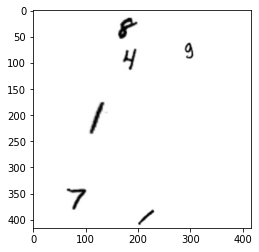

In [8]:
plt.imshow(image_data[0])

In [9]:
# Build Model
input_layer  = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLOv3(input_layer)

bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, i)
    bbox_tensors.append(bbox_tensor)

model = tf.keras.Model(input_layer, bbox_tensors)
model.load_weights("./data/log/yolov3")

In [12]:
pred_bbox = model.predict(image_data)
pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
pred_bbox = tf.concat(pred_bbox, axis=0)
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.3)
bboxes = utils.nms(bboxes, 0.45, method='nms')

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image = utils.draw_bbox(original_image, bboxes, classes=utils.read_class_names("./data/classes/yymnist.names"))
image = Image.fromarray(image)

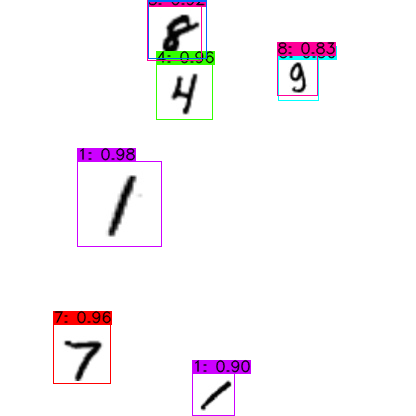

In [13]:
image